Group8 - Flooded area coverage prediction   
Wan-Chun Elena Liao  
Xinyi (Jessica) Wang

In [0]:
from datetime import datetime

import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
# from pyspark.ml.feature import StringIndexer
# from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

In [0]:
spark = SparkSession.builder.getOrCreate()

### Load data from MongoDB and Create features/label

(Elena Liao)

In [0]:
database = 'MSDS697-Cluster'
collection = 'GEE_IMAGE'
user_name = 'smilesun930'
password = 'Eelena831002'
address = 'msds697-cluster.6e9qx.mongodb.net'
connection_string = f"mongodb+srv://{user_name}:{password}@{address}/{database}.{collection}"

In [0]:
df = spark.read.format("mongo").option("uri",connection_string).load()

In [0]:
df.limit(5).collect()

Out[6]: [Row(B11='1997.0', B12=None, B2='2604', B3='2266', B4='2362', B5='2506.0', B6=None, B7=None, B8=None, B8A=None, _id=Row(oid='63faeef58fb077593669f7f4'), date=None, field=None),
 Row(B11='2009.0', B12=None, B2='2610', B3='2278', B4='2378', B5='2527.0', B6=None, B7=None, B8=None, B8A=None, _id=Row(oid='63faeef88fb077593669f7f5'), date=None, field=None),
 Row(B11='2003.0', B12=None, B2='2625', B3='2305', B4='2404', B5='2489.0', B6=None, B7=None, B8=None, B8A=None, _id=Row(oid='63faeef88fb077593669f7f6'), date=None, field=None),
 Row(B11='1980.0', B12=None, B2='2619', B3='2279', B4='2392', B5='2470.0', B6=None, B7=None, B8=None, B8A=None, _id=Row(oid='63faeef88fb077593669f7f7'), date=None, field=None),
 Row(B11='1967.0', B12=None, B2='2613', B3='2299', B4='2406', B5='2488.0', B6=None, B7=None, B8=None, B8A=None, _id=Row(oid='63faeef88fb077593669f7f8'), date=None, field=None)]

In [0]:
df.printSchema()

root
-- B11: string (nullable = true)
-- B12: string (nullable = true)
-- B2: string (nullable = true)
-- B3: string (nullable = true)
-- B4: string (nullable = true)
-- B5: string (nullable = true)
-- B6: string (nullable = true)
-- B7: string (nullable = true)
-- B8: string (nullable = true)
-- B8A: string (nullable = true)
-- _id: struct (nullable = true)
 |-- oid: string (nullable = true)
-- date: string (nullable = true)
-- field: array (nullable = true)
 |-- element: string (containsNull = true)

In [0]:
df.select(df['date']).distinct().show(5)

+----------+
 date|
+----------+
 null|
2023-02-27|
2023-03-07|
2023-03-03|
+----------+

In [0]:
df = df.filter(df['date'] != 'null')

In [0]:
df.show(5)

+----+---+---+---+---+----+----+----+---+----+--------------------+----------+-----+
 B11|B12| B2| B3| B4| B5| B6| B7| B8| B8A| _id| date|field|
+----+---+---+---+---+----+----+----+---+----+--------------------+----------+-----+
1432|883|129|170|145|1268|1739|1914|126|2017|[640833a775564833...|2023-03-07| null|
1540|936|111|178|154|1217|1786|1979|117|2115|[640833a775564833...|2023-03-07| null|
1460|908|132|124|111|1217|1740|1928|123|2110|[640833a875564833...|2023-03-07| null|
1447|902|145|142|178|1216|1661|1815|174|1909|[640833a875564833...|2023-03-07| null|
1406|877|118|170|122|1202|1563|1710|129|1858|[640833a875564833...|2023-03-07| null|
+----+---+---+---+---+----+----+----+---+----+--------------------+----------+-----+
only showing top 5 rows

In [0]:
df_all = df.select(col('B11').cast(IntegerType()),
              col('B12').cast(IntegerType()),
              col('B2').cast(IntegerType()),
              col('B3').cast(IntegerType()),
              col('B4').cast(IntegerType()),
#               col('B5').cast(IntegerType()),
#               col('B6').cast(IntegerType()),
#               col('B7').cast(IntegerType()),
              col('B8').cast(IntegerType()),
#               col('B8A').cast(IntegerType()),
              to_date(col('date')).alias('date')
             )

In [0]:
## create label by Normalized Difference Water Index based on B3 and B8 bands 
threshold = 0.25
df_ndwi = df_all.withColumn('ndwi', (df_all.B3 - df_all.B8)/(df_all.B3+df_all.B8))
df_ndwi = df_ndwi.withColumn('label', (df_ndwi.ndwi >threshold).cast("integer"))

In [0]:
df_ndwi.printSchema()

root
-- B11: integer (nullable = true)
-- B12: integer (nullable = true)
-- B2: integer (nullable = true)
-- B3: integer (nullable = true)
-- B4: integer (nullable = true)
-- B8: integer (nullable = true)
-- date: date (nullable = true)
-- ndwi: double (nullable = true)
-- label: integer (nullable = true)

In [0]:
# develop data frame for each date
df_227 = df_ndwi.filter(df['date']=='2023-02-27')
df_303 = df_ndwi.filter(df['date']=='2023-03-03')
df_307 = df_ndwi.filter(df['date']=='2023-03-07')

In [0]:
df_ndwi.show(5)

+----+---+---+---+---+---+----------+--------------------+-----+
 B11|B12| B2| B3| B4| B8| date| ndwi|label|
+----+---+---+---+---+---+----------+--------------------+-----+
1432|883|129|170|145|126|2023-03-07| 0.14864864864864866| 0|
1540|936|111|178|154|117|2023-03-07| 0.20677966101694914| 0|
1460|908|132|124|111|123|2023-03-07|0.004048582995951417| 0|
1447|902|145|142|178|174|2023-03-07|-0.10126582278481013| 0|
1406|877|118|170|122|129|2023-03-07| 0.13712374581939799| 0|
+----+---+---+---+---+---+----------+--------------------+-----+
only showing top 5 rows

In [0]:
df_303.show(5)

+----+----+---+---+---+---+----------+------------------+-----+
 B11| B12| B2| B3| B4| B8| date| ndwi|label|
+----+----+---+---+---+---+----------+------------------+-----+
3603|2822|162|222| 32| 47|2023-03-03|0.6505576208178439| 1|
3588|2827|131|240| 29| 35|2023-03-03|0.7454545454545455| 1|
3591|2828|127|184| 28| 18|2023-03-03|0.8217821782178217| 1|
3593|2823|218|145|145| 7|2023-03-03|0.9078947368421053| 1|
3591|2801|149|233| 70| 58|2023-03-03|0.6013745704467354| 1|
+----+----+---+---+---+---+----------+------------------+-----+
only showing top 5 rows

# Build a pipeline for:
- vector assembler
- standard scaler    
(Elena Liao)

In [0]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans

In [0]:
# vector Assemble
va = VectorAssembler(outputCol="features_1", inputCols=df_ndwi.columns[:-3]) #except the last col.
# standard Scaler
scl = StandardScaler(withMean=True, withStd=True, inputCol="features_1", outputCol="features")

pipeline = Pipeline(stages=[va, scl])

In [0]:
# fit the pipeline
p_model = pipeline.fit(df_ndwi)
# transform dataframes
out_227 = p_model.transform(df_227).select('features', 'label')
out_303 = p_model.transform(df_303).select('features', 'label')
out_307 = p_model.transform(df_307).select('features', 'label')
out_all = p_model.transform(df_ndwi).select('features', 'label')

In [0]:
out_303.select('features').show(100)


+--------------------+
 features|
+--------------------+
[1.72032137155364...|
[1.70439527302140...|
[1.70758049272785...|
[1.70970397253215...|
[1.70758049272785...|
[1.69377787399991...|
[1.68740743458702...|
[1.68634569468487...|
[1.67785177546767...|
[1.65661697742469...|
[1.66192567693544...|
[1.66511089664188...|
[1.66086393703329...|
[1.65980219713114...|
[1.62051782075162...|
[1.59715954290434...|
[1.60459172221938...|
[1.59503606310004...|
[1.58548040398070...|
[1.57910996456781...|
[1.57273952515491...|
[1.57486300495921...|
[1.60352998231724...|
[1.58441866407855...|
[1.57910996456781...|
[1.58548040398070...|
[1.56636908574202...|
[1.54088732809044...|
[1.54619602760118...|
[1.54194906799259...|
[1.55362820691623...|
[1.56106038623127...|
[1.55150472711193...|
[1.53451688867754...|
[1.51859079014530...|
[1.51115861083026...|
[1.50478817141737...|
[1.50691165122166...|
[1.49841773200447...|
[1.51009687092811...|
[1.51115861083026...|
[1.50054121180877...|
[1.73200051047728...|
[1.71182745233645...|
[1.71501267204289...|
[1.71501267204289...|
[1.69802483360851...|
[1.70333353311925...|
[1.70014831341281...|
[1.69483961390206...|
[1.68316047497842...|
[1.66298741683759...|
[1.64493783850105...|
[1.63856739908816...|
[1.64069087889245...|
[1.64069087889245...|
[1.61733260104517...|
[1.59715954290434...|
[1.58548040398070...|
[1.58017170446995...|
[1.56849256554631...|
[1.55468994681838...|
[1.56955430544846...|
[1.59078910349145...|
[1.58441866407855...|
[1.57061604535061...|
[1.58017170446995...|
[1.57273952515491...|
[1.57380126505706...|
[1.56318386603557...|
[1.54407254779688...|
[1.54407254779688...|
[1.54619602760118...|
[1.54831950740548...|
[1.54513428769903...|
[1.54301080789473...|
[1.51540557043886...|
[1.50160295171092...|
[1.50797339112381...|
[1.51646731034101...|
[1.50797339112381...|
[1.49947947190662...|
[1.51009687092811...|
[1.49735599210232...|
[1.72881529077083...|
[1.72032137155364...|
[1.70545701292355...|
[1.70121005331496...|
[1.69802483360851...|
[1.71076571243430...|
[1.72032137155364...|
[1.68846917448917...|
[1.65130827791395...|
[1.62688826016452...|
[1.60777694192583...|
[1.61839434094732...|
[1.60034476261079...|
[1.59503606310004...|
[1.59185084339359...|
[1.56955430544846...|
+--------------------+
only showing top 100 rows

## Apply KMeans algorithm to the data frame
(Elena Liao)

In [0]:
# k = 2 as there are 10 different handwritten numbers.
kmeans =  KMeans(k = 2, maxIter = 300, tol = 0.01) 
model = kmeans.fit(out_all)
predictions_227 = model.transform(out_227)
predictions_303 = model.transform(out_303)
predictions_307 = model.transform(out_307)
predictions_all = model.transform(out_all)

In [0]:
predictions_227.show()

+--------------------+-----+----------+
 features|label|prediction|
+--------------------+-----+----------+
[0.01516708870213...| 0| 0|
[0.02790796752792...| 0| 0|
[0.02153752811503...| 0| 0|
[-0.0028824896343...| 0| 0|
[-0.0166851083623...| 1| 0|
[-0.0368581665031...| 1| 0|
[-0.0612781842526...| 1| 0|
[-0.0878216818063...| 1| 0|
[-0.0835747221977...| 1| 0|
[-0.0846364620998...| 1| 0|
[-0.0665868837633...| 1| 0|
[-0.0814512423934...| 1| 0|
[-0.1069330000450...| 0| 0|
[-0.1228590985772...| 1| 0|
[-0.1525878158374...| 1| 0|
[-0.1387851971094...| 0| 0|
[-0.1366617173051...| 1| 0|
[-0.1483408562288...| 1| 0|
[-0.1387851971094...| 0| 0|
[-0.1324147576965...| 0| 0|
+--------------------+-----+----------+
only showing top 20 rows

In [0]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 0.60487006 0.63028228 0.25124915 0.08309417 -0.12139696 -0.02620032]
[-1.26923553 -1.32255953 -0.52721133 -0.17436155 0.25473461 0.05497772]

In [0]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions_all)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.44233969885119134

In [0]:
predictions_all.groupBy('prediction').count().show()

+----------+-----+
prediction|count|
+----------+-----+
 1| 3290|
 0| 6916|
+----------+-----+

# Results for each date
(Jessica Wang)

In [0]:
predictions_all.select('label', 'prediction')\
           .groupBy('label', 'prediction')\
           .count().show()

+-----+----------+-----+
label|prediction|count|
+-----+----------+-----+
 1| 0| 1989|
 1| 1| 519|
 0| 0| 4927|
 0| 1| 2771|
+-----+----------+-----+

In [0]:
predictions_227.select('label', 'prediction')\
           .groupBy('label', 'prediction')\
           .count()\
           .show()

+-----+----------+-----+
label|prediction|count|
+-----+----------+-----+
 1| 0| 919|
 1| 1| 3|
 0| 0| 2465|
 0| 1| 15|
+-----+----------+-----+

In [0]:
predictions_303.select('label', 'prediction')\
           .groupBy('label', 'prediction')\
           .count()\
           .show()

+-----+----------+-----+
label|prediction|count|
+-----+----------+-----+
 1| 0| 1038|
 0| 0| 2364|
+-----+----------+-----+

In [0]:
predictions_307.select('label', 'prediction')\
           .groupBy('label', 'prediction')\
           .count()\
           .show()

+-----+----------+-----+
label|prediction|count|
+-----+----------+-----+
 1| 0| 32|
 1| 1| 516|
 0| 0| 98|
 0| 1| 2756|
+-----+----------+-----+

From the results above, it can be seen that 70% to 80% of the results matches for two estimation approaches.

# Results Visulization
(Jessica Wang)

## Date of 2023-02-27

In [0]:
# convert prediction, label and visible bands to a array image
a = np.array(predictions_227.select('prediction').collect())
pred_array = a.reshape(81, 42)
b = np.array(predictions_227.select('label').collect())
label_array = b.reshape(81, 42)
color = df_227.select('B4', 'B3', 'B2')\
.withColumn('B4n', df_ndwi['B4']/255 )\
.withColumn('B3n', df_ndwi['B3']/255 )\
.withColumn('B2n', df_ndwi['B2']/255)
picture = np.array(color.select('B2n', 'B3n', 'B4n').collect())
picture = picture.reshape(81,42,3)

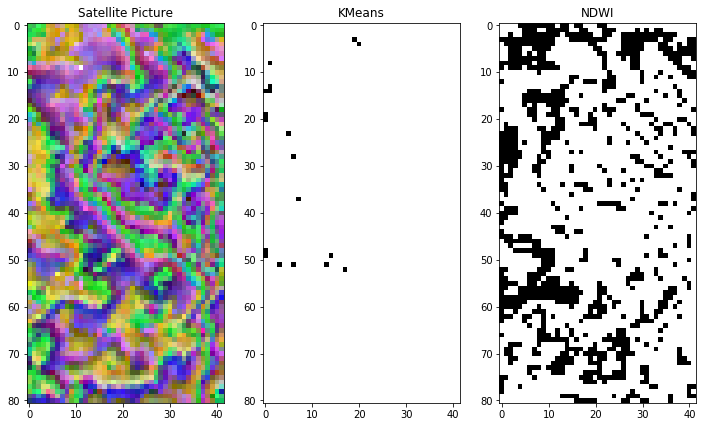

In [0]:
# plot the results and compar
fig, axes =plt.subplots(1,3, figsize = (12,8))
axes = axes.flatten()
axes[0].imshow(picture)
axes[1].imshow(pred_array, cmap='binary')
axes[2].imshow(label_array, cmap='binary')

axes[0].set_title('Satellite Picture')
axes[1].set_title('KMeans')
axes[2].set_title('NDWI')

plt.show()


## Date of 2023-03-03

In [0]:
# convert prediction, label and visible bands to a array image
a = np.array(predictions_303.select('prediction').collect())
pred_array = a.reshape(81, 42)
b = np.array(predictions_303.select('label').collect())
label_array = b.reshape(81, 42)
color = df_303.select('B4', 'B3', 'B2')\
.withColumn('B4n', df_ndwi['B4']/255 )\
.withColumn('B3n', df_ndwi['B3']/255 )\
.withColumn('B2n', df_ndwi['B2']/255)
picture = np.array(color.select('B2n', 'B3n', 'B4n').collect())
picture = picture.reshape(81,42,3)

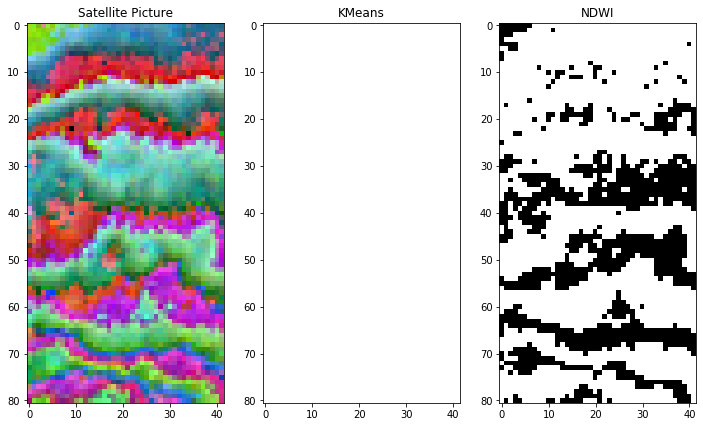

In [0]:
# plot the results and compar
fig, axes =plt.subplots(1,3, figsize = (12,8))
axes = axes.flatten()
axes[0].imshow(picture)
axes[1].imshow(pred_array, cmap='binary')
axes[2].imshow(label_array, cmap='binary')

axes[0].set_title('Satellite Picture')
axes[1].set_title('KMeans')
axes[2].set_title('NDWI')

plt.show()


Out[111]: 0.6663727219282775

## Date of 2023-03-07

In [0]:
# convert prediction, label and visible bands to a array image
a = np.array(predictions_307.select('prediction').collect())
pred_array = a.reshape(81, 42)
b = np.array(predictions_307.select('label').collect())
label_array = b.reshape(81, 42)
color = df_307.select('B4', 'B3', 'B2')\
.withColumn('B4n', df_ndwi['B4']/255 )\
.withColumn('B3n', df_ndwi['B3']/255 )\
.withColumn('B2n', df_ndwi['B2']/255)
picture = np.array(color.select('B2n', 'B3n', 'B4n').collect())
picture = picture.reshape(81,42,3)

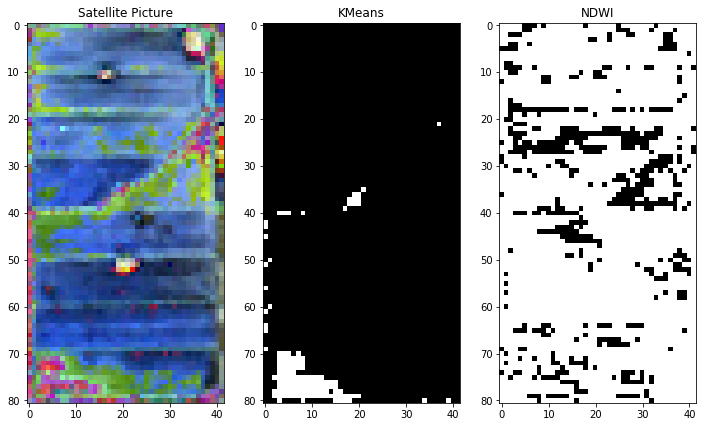

In [0]:
# plot the results and compar
fig, axes =plt.subplots(1,3, figsize = (12,8))
axes = axes.flatten()
axes[0].imshow(picture)
axes[1].imshow(pred_array, cmap='binary')
axes[2].imshow(label_array, cmap='binary')

axes[0].set_title('Satellite Picture')
axes[1].set_title('KMeans')
axes[2].set_title('NDWI')
plt.show()


From the plots above, it can be seen that either K-menas or NDWI works well for cloudy days. Based on the visual check, k-means provide resonable results,but not accurate.   
For the next step, we plan to use the data from not cloudy days to train the model and transform.

In [0]:
# retrin the model with not cloudly date
# k = 2 flooded or not flooded
kmeans =  KMeans(k = 2, maxIter = 300, tol = 0.01) 
model = kmeans.fit(out_307)
predictions = model.transform(out_307)

In [0]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.35177181627007903

In [0]:
# convert prediction, label and visible bands to a array image
a = np.array(predictions.select('prediction').collect())
pred_array = a.reshape(81, 42)
b = np.array(predictions.select('label').collect())
label_array = b.reshape(81, 42)
color = df_307.select('B4', 'B3', 'B2')\
.withColumn('B4n', df_ndwi['B4']/255 )\
.withColumn('B3n', df_ndwi['B3']/255 )\
.withColumn('B2n', df_ndwi['B2']/255)
picture = np.array(color.select('B2n', 'B3n', 'B4n').collect())
picture = picture.reshape(81,42,3)

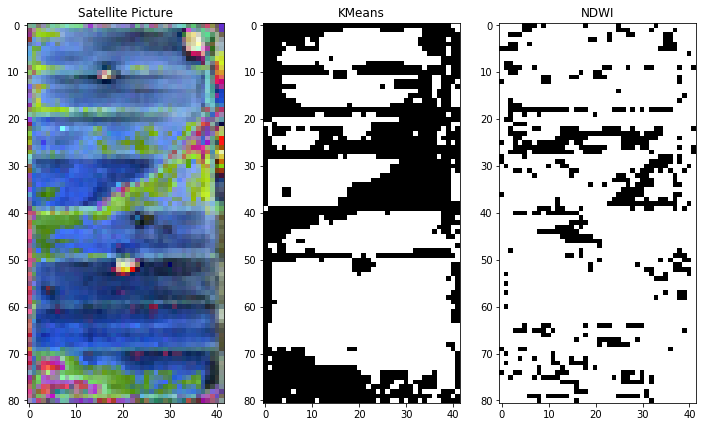

In [0]:
# plot the results and compar
fig, axes =plt.subplots(1,3, figsize = (12,8))
axes = axes.flatten()
axes[0].imshow(picture)
axes[1].imshow(pred_array, cmap='binary')
axes[2].imshow(label_array, cmap='binary')
axes[0].set_title('Satellite Picture')
axes[1].set_title('KMeans')
axes[2].set_title('NDWI')

plt.show()

For the date of Mar 7, it is clear that there was no cloud coverage and the plot shows promising clustering outcomes from KMeans. For the K-means plot above, the white areas are identified as a flooded and the black area are identified as land. The clustering results match the satellite picture presentation and more sensitive the the shallow flooded areas.